In [54]:
from importlib import reload
from collections import OrderedDict
import random
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn import svm
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import pandas as pd
import dill
import seaborn as sns

import libplot
import libregionplot

### Introductory Figure (1)

In [2]:
def generateData_twoPills_2D(dataset_size, noise=0.05, random_state=2210):
    data, labels = make_classification(
        n_samples=max(10000, dataset_size),
        n_features=3,
        n_informative=2,
        n_redundant=0,
        n_classes=2,
        n_clusters_per_class=1,
        flip_y=noise,  # noise
        random_state=random_state,
    )
    # the axis order changes if the noise parameter is adjusted. For the experiments on noise, we
    # set the correct order here such that the dataset always is mainly the same
    switcher = {0: (2, 1), 0.05: (0, 1), 0.1: (1, 0), 0.2: (2, 0), 0.5: (2, 1)}
    data = data[0:dataset_size, switcher.get(noise, (0, 1))]  # cut away dummy dimension
    labels = labels[0:dataset_size]
    return data, labels

In [3]:
from modAL import batch, ActiveLearner
from modAL.uncertainty import uncertainty_sampling
def plot_classification(ax, clf, X, Y, X_all, y_all, clf_all):
    """
    Plot the results of a classifier
    """
    from libplot import make_meshgrid, plot_contours
    
    marker_size = 50
    colours = ['black', 'red', 'green', 'blue']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X_all[:, 0], X_all[:, 1], h=0.01)

    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Draw initial boundary
    ax.contour(xx, yy, Z, colors=colours[0], levels=[0], alpha=1,
               linestyles=['-'])
    
    # Draw initial points
    round0 = Line2D([0], [0], color=colours[0], label="Initial round")
    ax.scatter(X0[Y==0], X1[Y==0], s=60, edgecolors="k", marker='^', color=colours[0], label="Positive")
    ax.scatter(X0[Y==1], X1[Y==1], s=60, edgecolors="k", color=colours[0], label="Negative")
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    round1 = Line2D([0], [0], color=colours[1], label="1st round")
    ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[1], s=marker_size)
    ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[1], s=marker_size)
    
    # --------
    
    clf.teach(X_all[chosen], y_all[chosen])
    
    # Draw next boundary
    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors=colours[1], levels=[0], alpha=1,
               linestyles=['-'])
    
    mask = np.ones(len(X_all), bool)
    mask[chosen] = 0
    X_all = X_all[mask]
    y_all = y_all[mask]
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    round2 = Line2D([0], [0], color=colours[2], label="2nd round")
    ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[2], s=marker_size)
    ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[2], s=marker_size)
    
    # --------
    
    clf.teach(X_all[chosen], y_all[chosen])
    
    # Draw next boundary
    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors=colours[2], levels=[0], alpha=1,
               linestyles=['-'])
    
    mask = np.ones(len(X_all), bool)
    mask[chosen] = 0
    X_all = X_all[mask]
    y_all = y_all[mask]
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    #ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[3], s=marker_size, label="3rd round")
    #ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[3], s=marker_size)
    
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend(handles=[*ax.get_legend_handles_labels()[0], round0, round1, round2])
    if ax is None:
        return fig

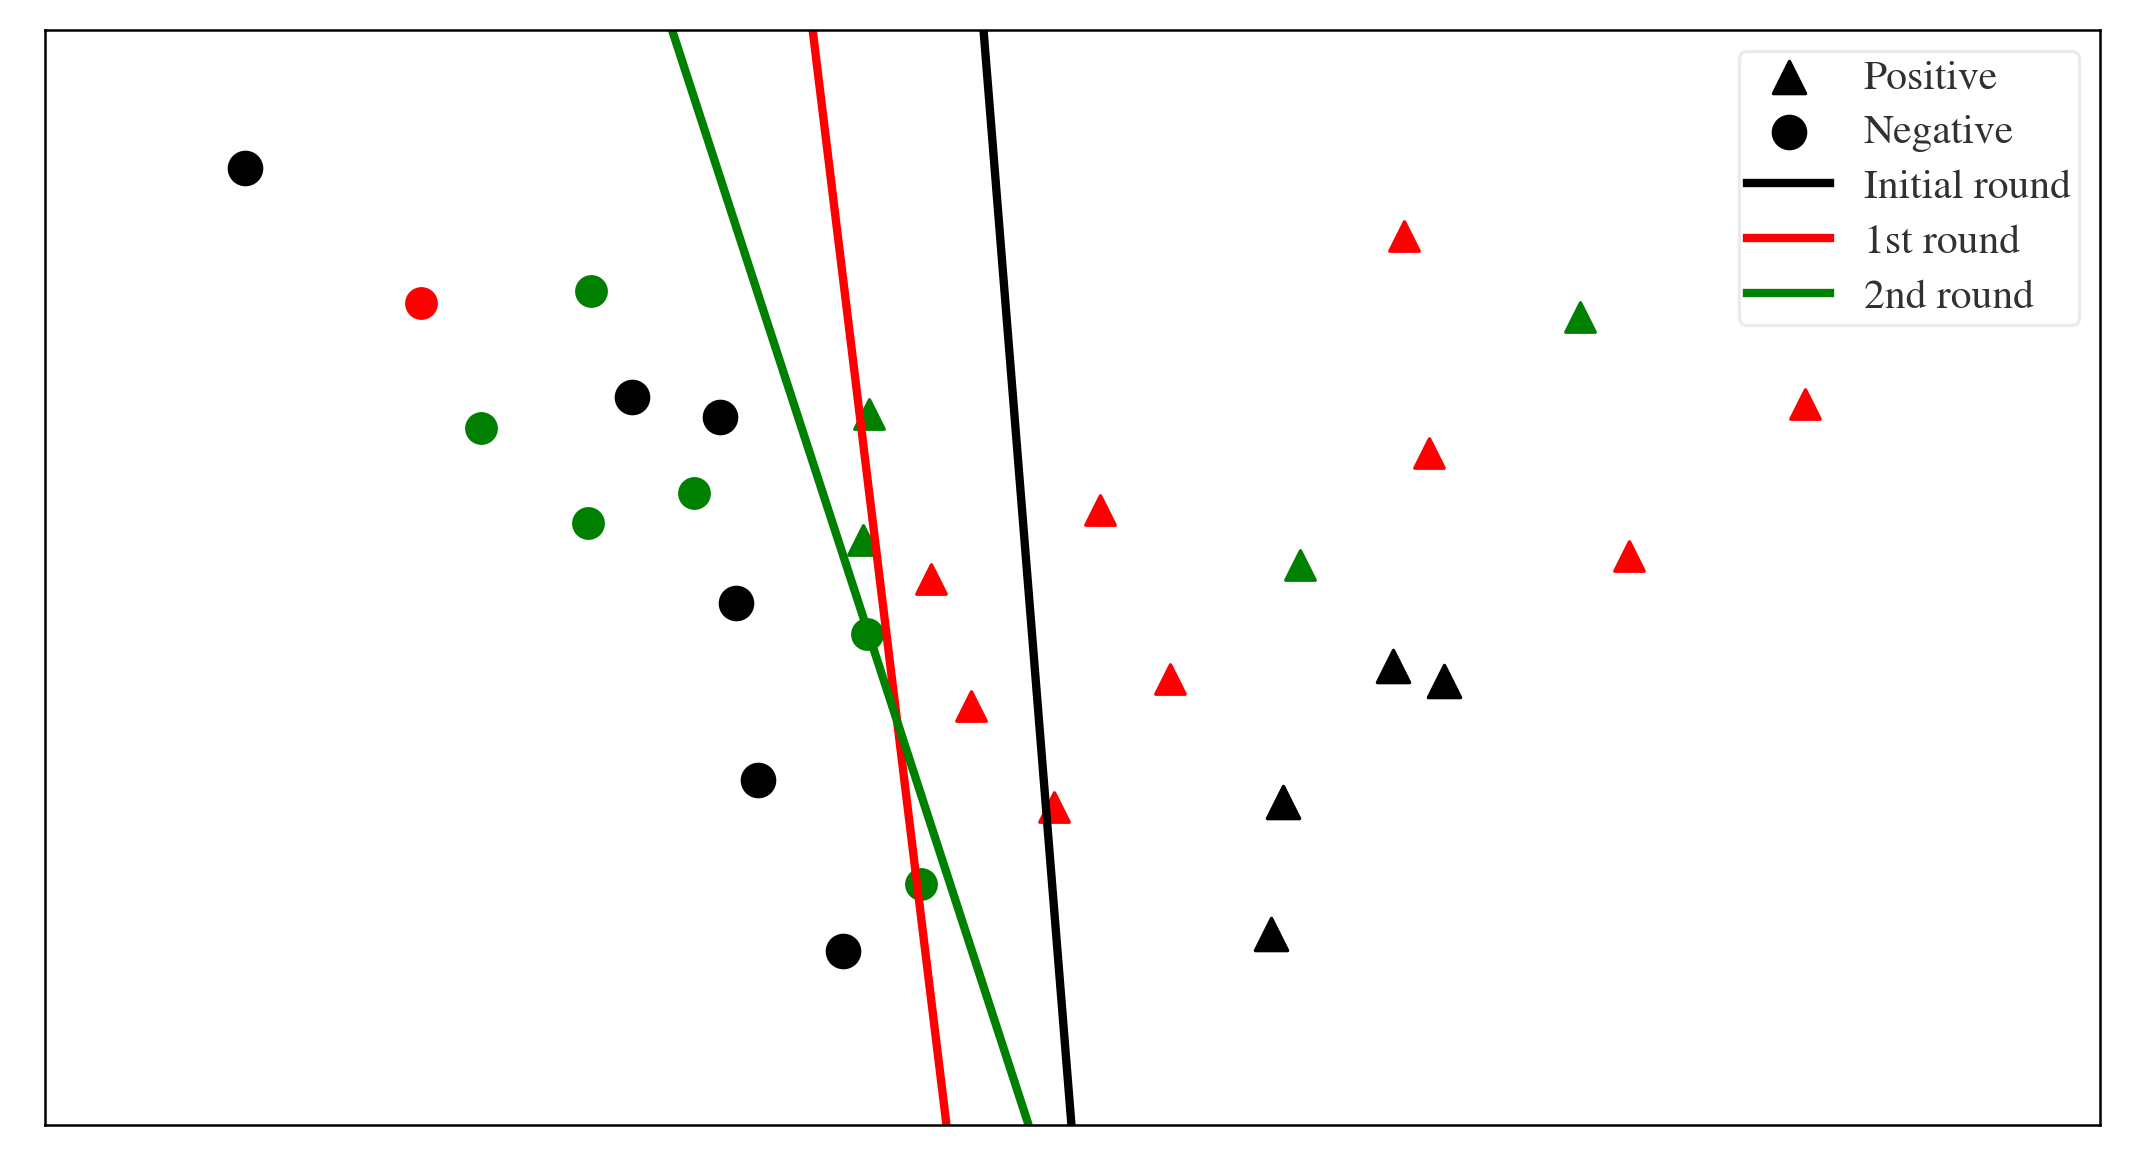

In [4]:
X, y = generateData_twoPills_2D(dataset_size=100)
np.random.seed(1231)

idx = np.random.choice(X.shape[0], 10, replace=False)

clf = ActiveLearner(estimator=svm.SVC(kernel='linear', probability=True), X_training=X[idx], y_training=y[idx], query_strategy=batch.uncertainty_batch_sampling)
clf_all = svm.SVC(kernel='linear', probability=True)
clf_all.fit(X,y)

mask = np.ones(len(X), bool)
mask[idx] = 0
X_all = X[mask]
y_all = y[mask]
with plt.style.context('plt_style.txt'):
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True

    fig, ax = plt.subplots(1, 1, figsize=(7.2, 4.), dpi=300)
    plot_classification(ax, clf, X[idx], y[idx], X_all, y_all, clf_all)
    fig.tight_layout()
    fig.savefig('figures/svm_decision_boundary.png')

### Failed to Stop Data

In [7]:
pd.read_csv('failed_to_stop.csv')

,Unnamed: 0,SSNCut,SC_entropy_mcs,SC_oracle_acc,Stabilizing Predictions,Performance Convergence,Uncertainty Convergence,Max Confidence,EVM,VM,Contradictory Information,Classification Change,Overall Uncertainty
0,rcv1,30/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
1,webkb,0/30,0/30,30/30,30/30,0/30,0/30,25/30,30/30,30/30,30/30,30/30,13/30
2,spamassassin,30/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
3,avila,30/30,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,0/30
4,smartphone,0/30,0/30,30/30,30/30,0/30,0/30,3/30,30/30,30/30,30/30,30/30,30/30
5,swarm,30/30,30/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
6,sensorless,0/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
7,splice,0/30,0/30,30/30,30/30,0/30,0/30,26/30,30/30,30/30,30/30,30/30,30/30
8,anuran,0/30,0/30,30/30,30/30,0/30,0/30,5/30,30/30,30/30,30/30,30/30,30/30


## Data Loading For Below

In [62]:
from dotenv import load_dotenv; load_dotenv(); from libutil import out_dir
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)
results = {}
for name in ['rcv1-58509','webkb','spamassassin','avila','smartphone','swarm','sensorless','splice','anuran']:
    results[name] = read_stopping(name)
to_plot_min = ['Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information']
results_filter_min = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}

### Colour Map

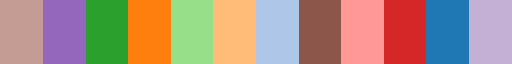

In [63]:
colors = sns.color_palette('tab20', len(to_plot_min)).as_hex()
random.seed(10); random.shuffle(colors)
criteria_map = {name: color for name, color in zip(to_plot_min, colors)}
cmap = ListedColormap(colors, name='Z'); cmap

In [65]:
criteria_map

{'Overall Uncertainty': '#c49c94',
 'Performance Convergence': '#9467bd',
 'Max Confidence': '#2ca02c',
 'VM': '#ff7f0e',
 'SC_entropy_mcs': '#98df8a',
 'SC_oracle_acc': '#ffbb78',
 'EVM': '#aec7e8',
 'SSNCut': '#8c564b',
 'Stabilizing Predictions': '#ff9896',
 'Uncertainty Convergence': '#d62728',
 'Classification Change': '#1f77b4',
 'Contradictory Information': '#c5b0d5'}

Feel free to play around with these colours. Pick a couple of colours from the colourmap to use for the introductory plot.

### Pareto Plots

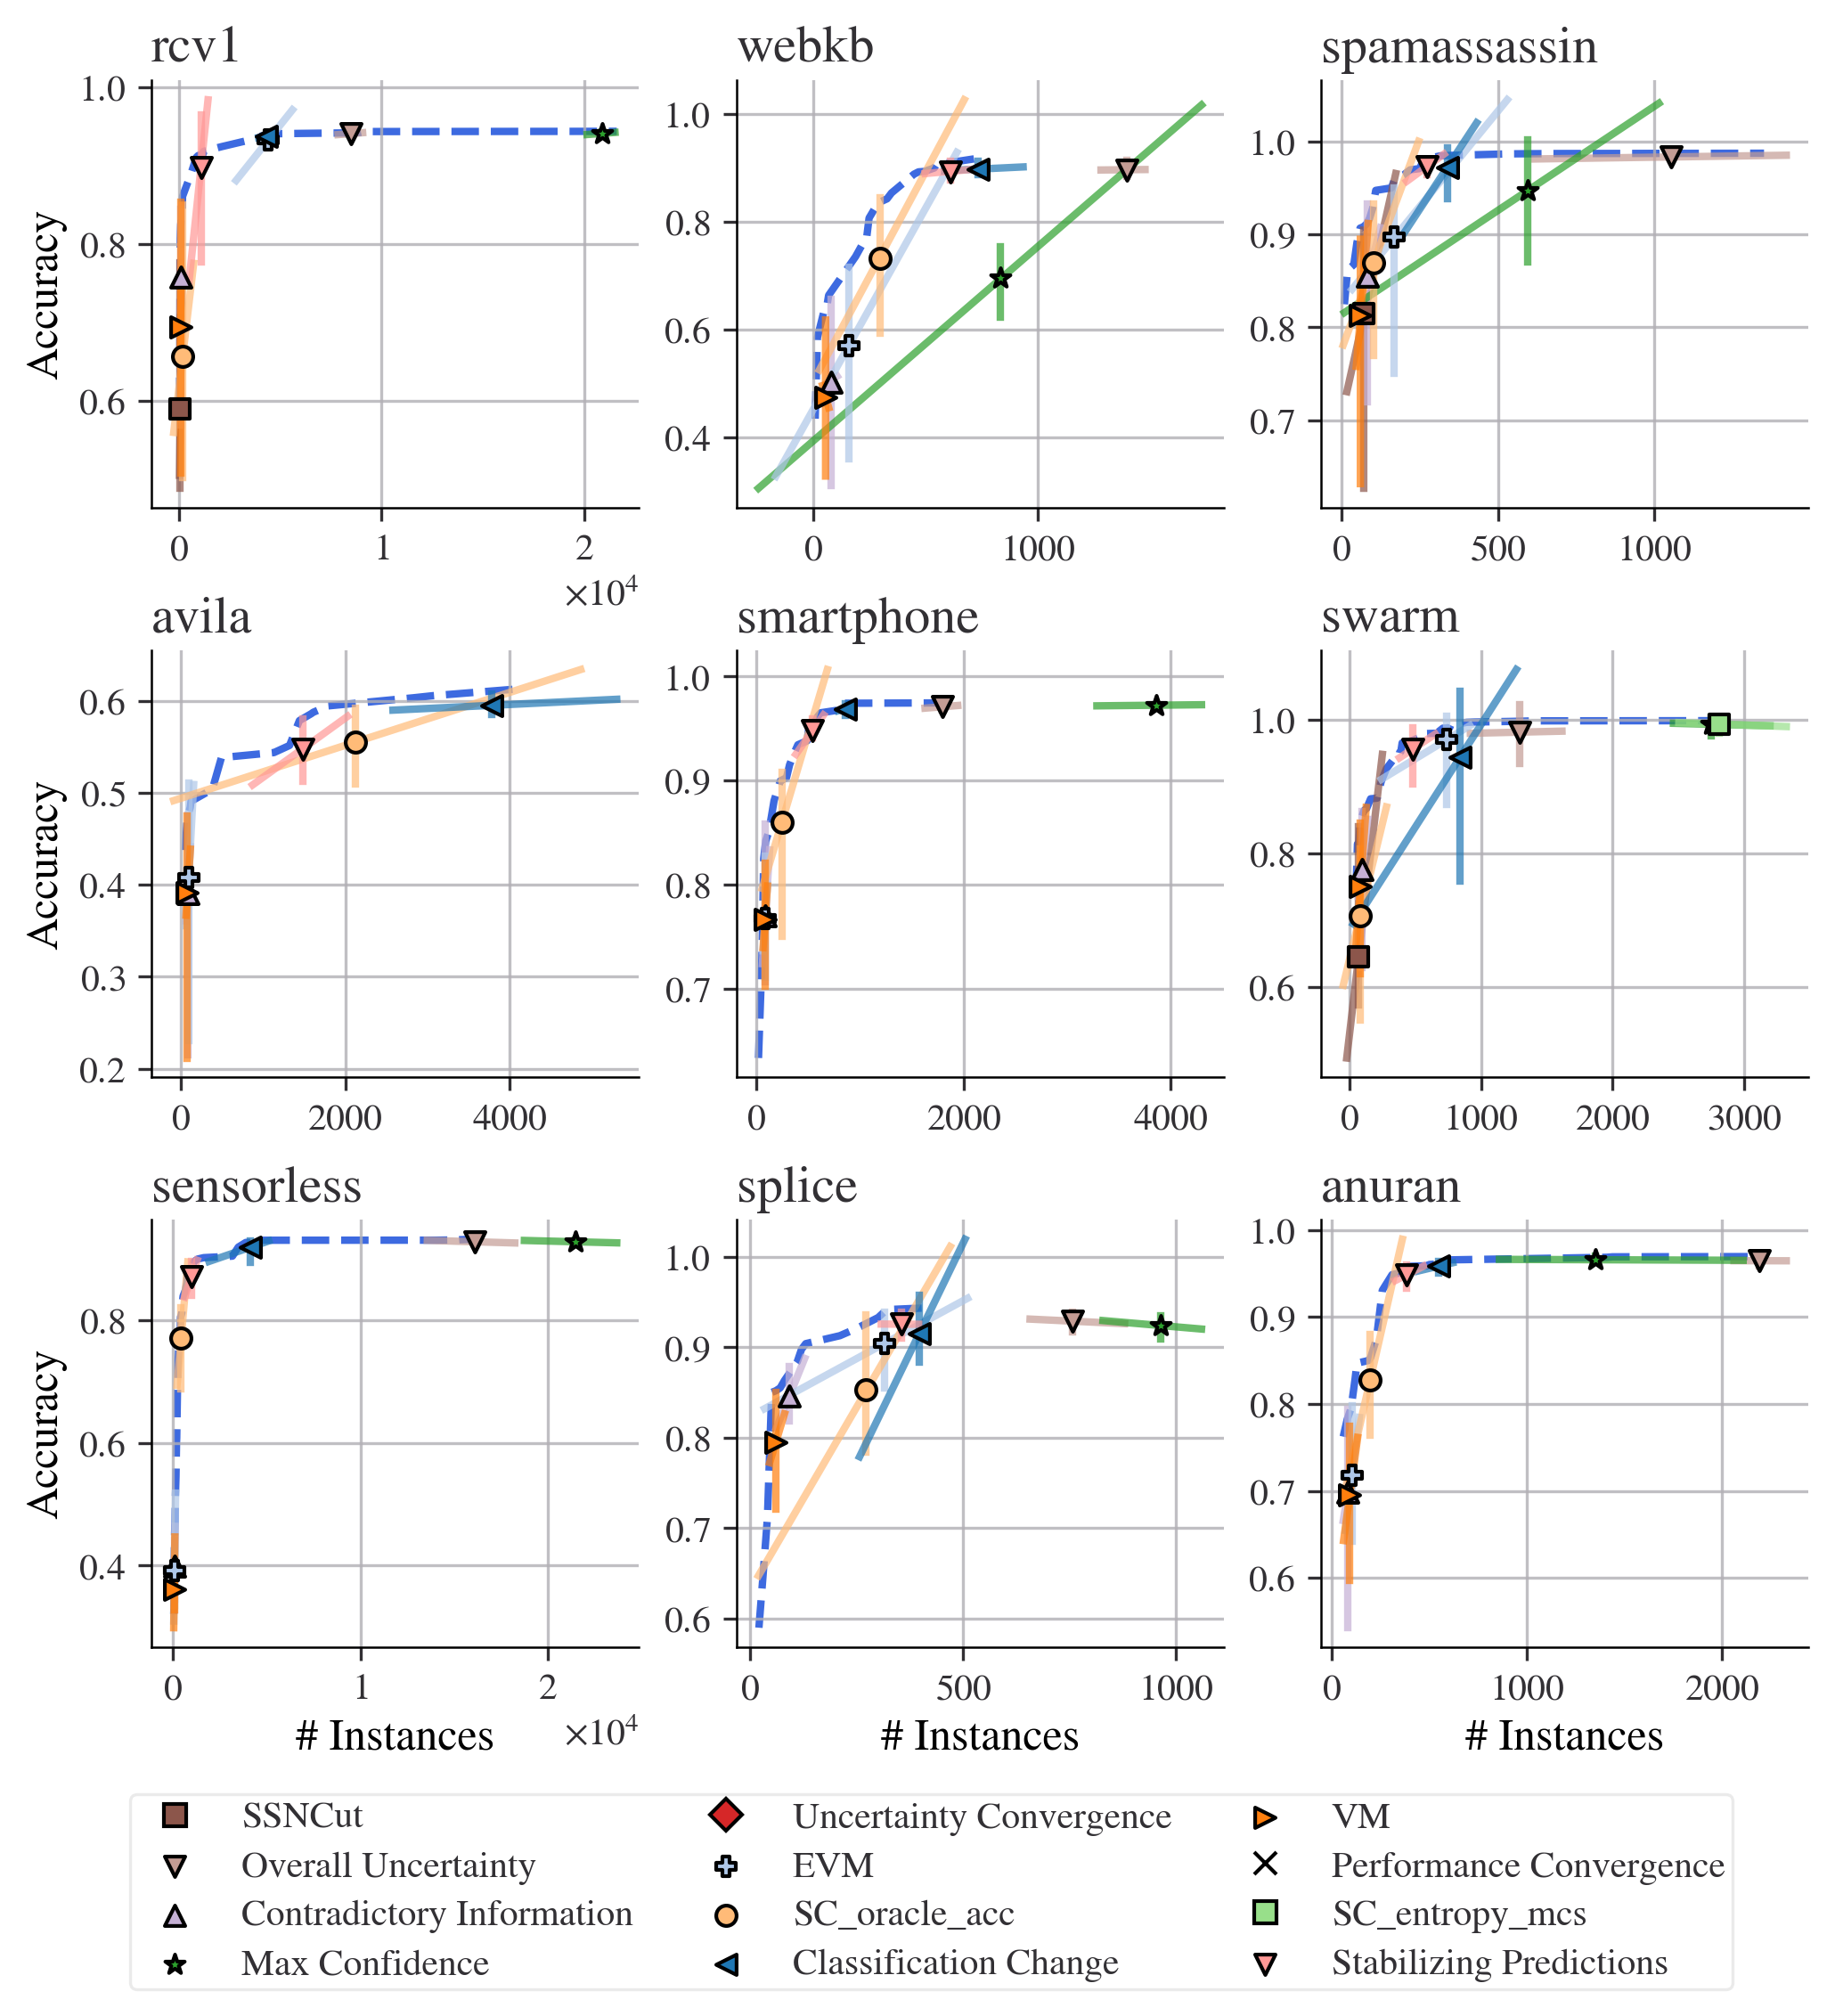

In [64]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter_min, rows=3, cols=3, figsize=(8,8), dpi=300, hull=False, error='pca', colors=criteria_map, legend_loc='upper center', legend_cols=3, legend_bbox=(-0.8, -0.3))

### Cost Plots

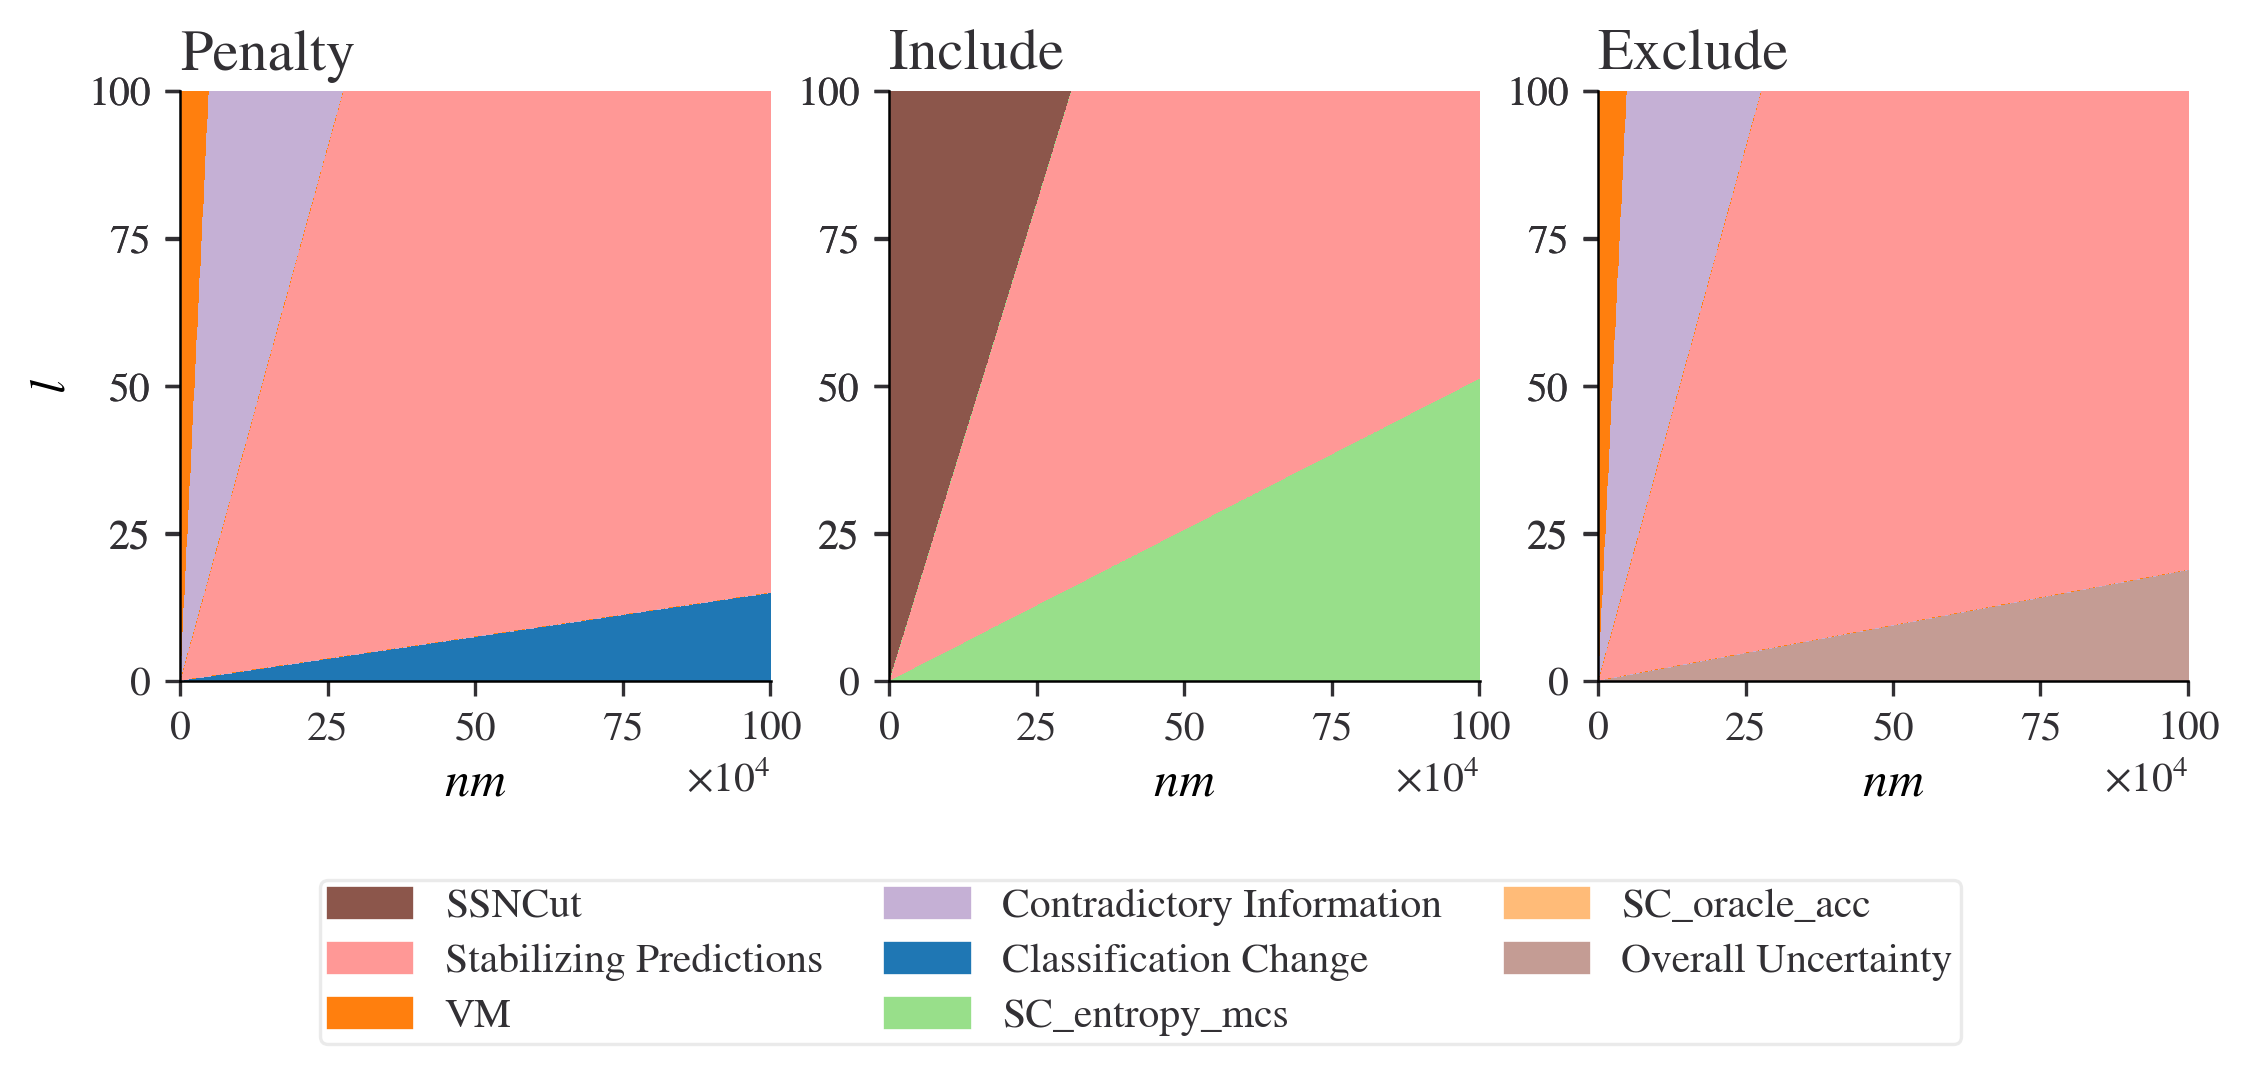

In [48]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=300)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.65, -0.3), ncol=3)
#plt.tight_layout()

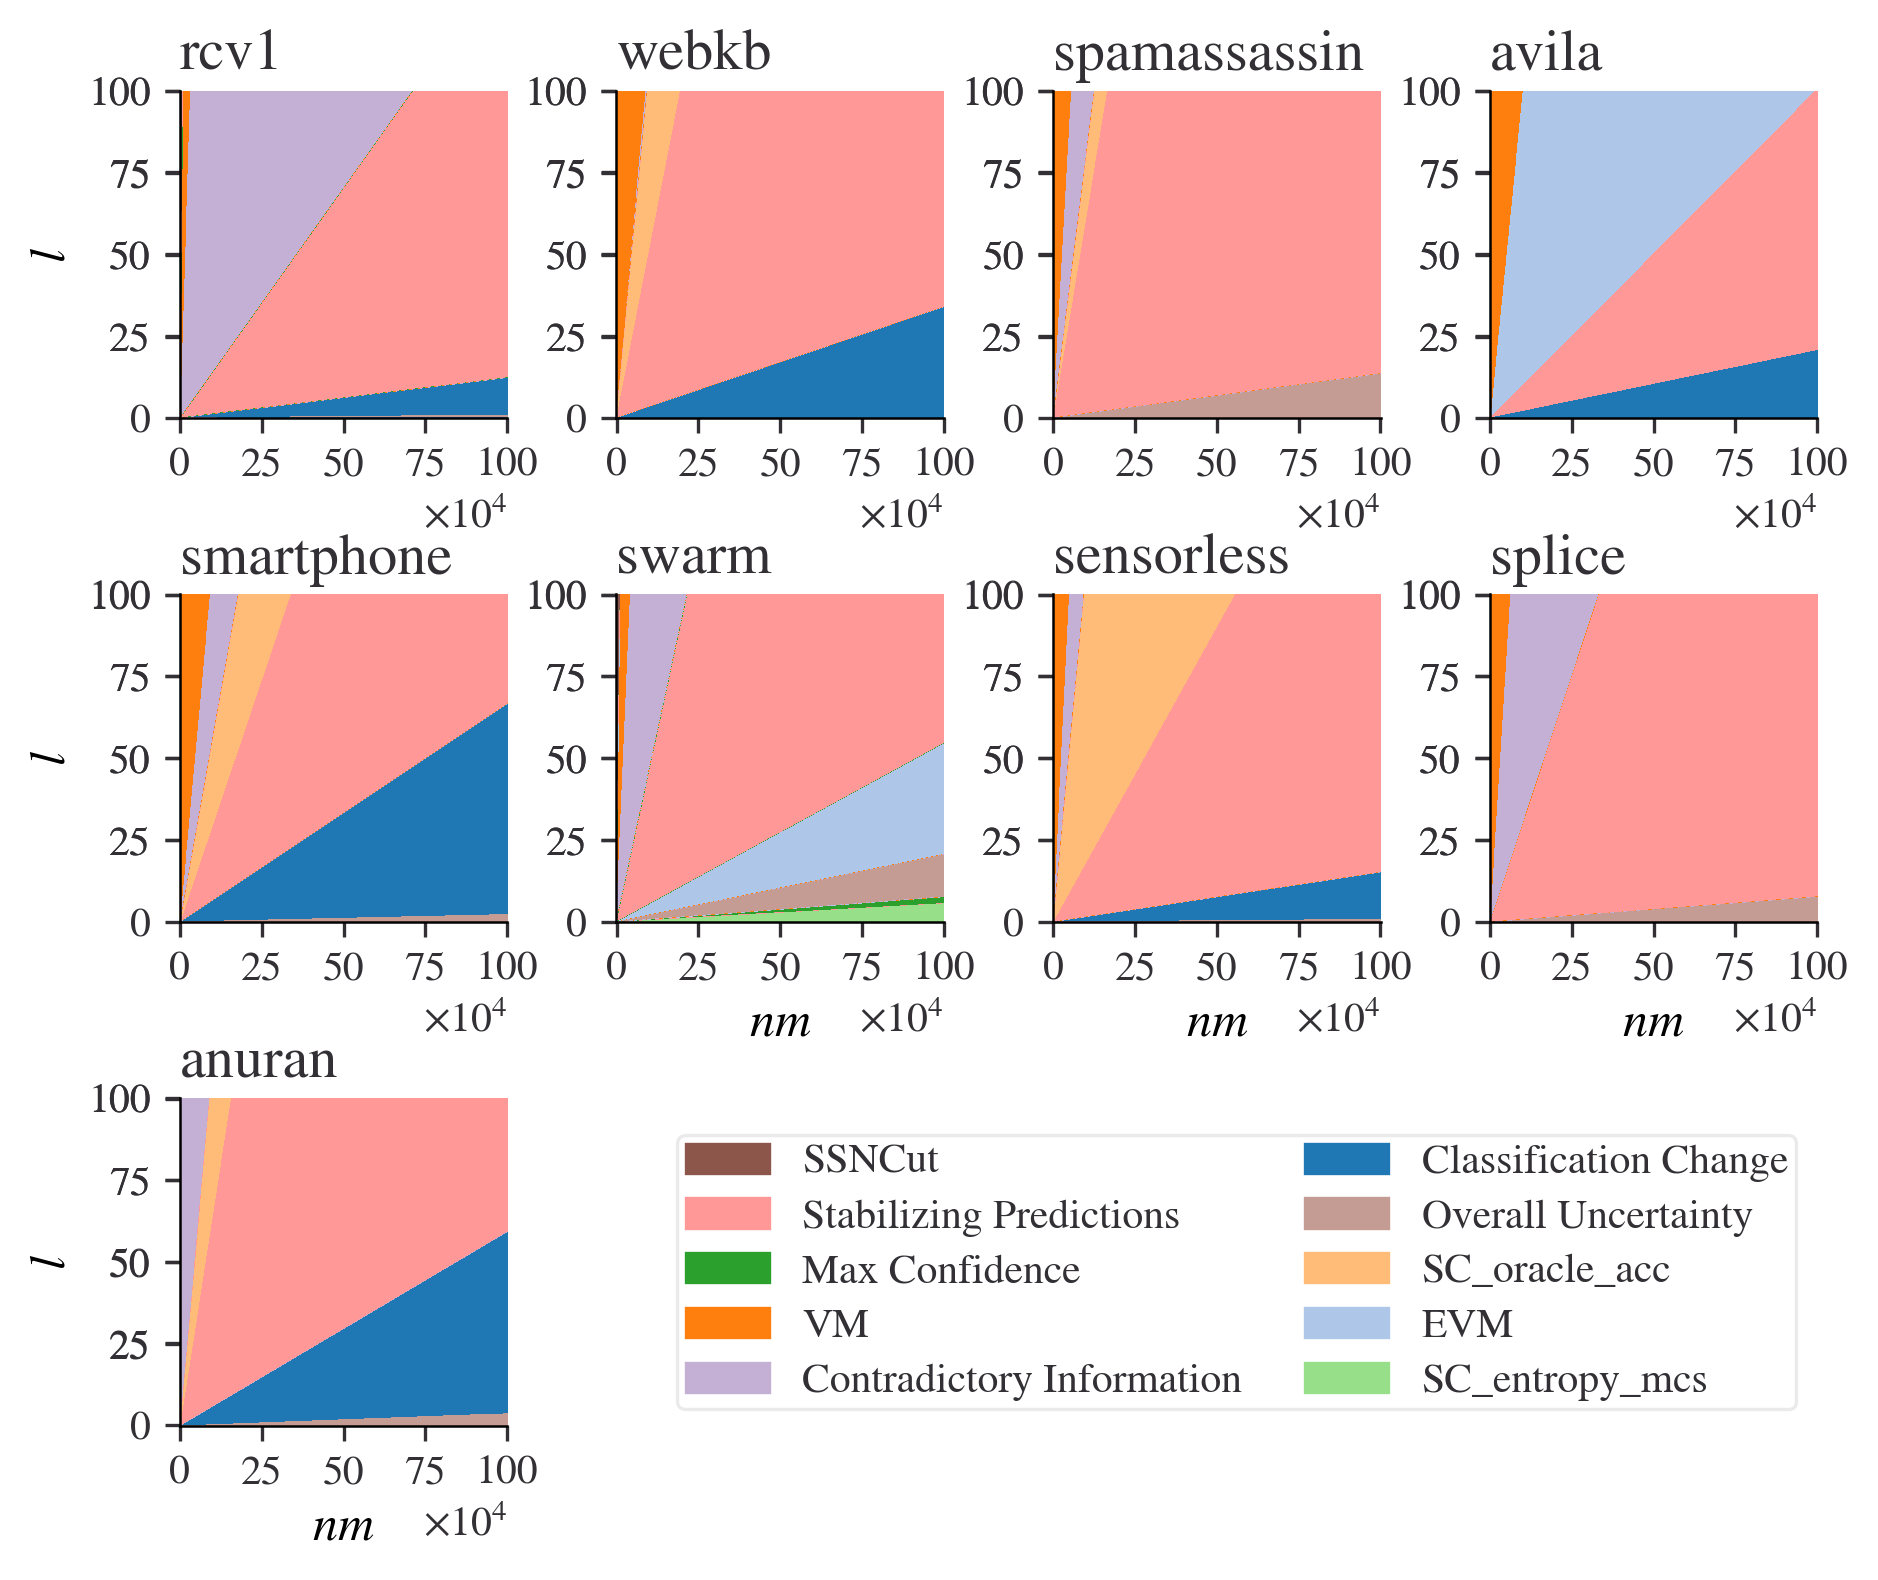

In [51]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(7.2,6.3), dpi=300)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
        regions(
            {dataset: r}, 
            colors=criteria_map, 
            failed_to_stop="penalty", 
            title=dataset.rstrip("-58509"), 
            ax=ax, 
            patches=patches, 
            left=i%4==0, 
            bottom=i>len(results_filter_min)-5)
    for ax in axes.flatten()[len(results_filter_min):]:
        fig.delaxes(ax)
    for ax in axes.flatten():
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
    plt.legend(handles=patches, bbox_to_anchor=(5., 0.95), ncol=2)
    #plt.suptitle("Linear SVM (Penalty)")

### Autorank (For examples)

In [53]:
import libregionplot; reload(libregionplot); from libregionplot import *
interactive_explore_cost(results_filter_min, title="Marketing Example")

interactive(children=(IntText(value=87600, description='Expected number of misclassifications n:'), FloatText(…